<a href="https://colab.research.google.com/github/mahidhiman12/Deep_learning_with_PyTorch/blob/main/8_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Our previous model's performance up until now is pretty bad. Often times , theres always a well performing model that exists for our problem.We can use it : This technique is called **`transfer learning`**

**What is transfer learning?**

Transfer learning allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as ImageNet (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a language model (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

The premise remains: find a well-performing existing model and apply it to your own problem.

In the case of computer vision, a computer vision model might learn patterns on millions of images in ImageNet and then use those patterns to infer on another problem. And for NLP, a language model may learn the structure of language by reading all of Wikipedia (and perhaps more) and then apply that knowledge to a different problem.

**Why should we use transfer learning:**

There are two main benefits to using transfer learning:

Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
Can leverage a working model which has already learned patterns on similar data to our own. This often results in achieving great results with less custom data.

We'll be putting these to the test for our FoodVision Mini problem, we'll take a computer vision model pretrained on ImageNet and try to leverage its underlying learned representations for classifying images of pizza, steak and sushi.

> A study into the effects of whether training from scratch or using transfer learning was better from a practitioner's point of view, found transfer learning to be far more beneficial in terms of cost and time.

Where can we find pretrained models ?

| **Location** | **What's there?** | **Link(s)** |
| ----- | ----- | ----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets |
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ |



> state of the art : State-of-the-art (SOTA) machine learning refers to the most advanced and accurate models, algorithms, and techniques currently available for a specific task.


**We're going to take a pretrained model from torchvision.models and customise it to work on our FoodVision Mini problem.**

In [1]:
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
torch version: 2.9.0+cu128
torchvision version: 0.24.0+cu128


In [2]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mahidhiman12/Deep_learning_with_PyTorch
    !mv Deep_learning_with_PyTorch/going_modular .
    !rm -rf Deep_learning_with_PyTorch
    from going_modular import data_setup, engine

## 0. Getting Setup

Lets start by leveraging some of the Python Scripts we created in last notebook.

- We will download `going_modular` directory
- `torchinfo` will help later on to give us a visual representation of our model.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Get data:

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using for FoodVision Mini.

In [4]:
import os
import zipfile
from pathlib import Path
import requests
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [5]:
train_dir = image_path/"train"
test_dir = image_path / "test"

## 2. Create datasets and dataloaders

Since we've downloaded the going_modular directory, we can use the data_setup.py script we created in section 07. PyTorch Going Modular to prepare and setup our DataLoaders.
We will call this `manual creation`

But since we'll be using a pretrained model from torchvision.models, there's a specific transform we need to prepare our images first. We will call this `auto creation`

### 2.1 Manual Creation

> **When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.**

Prior to `torchvision` v0.13+, to create a transform for a pretrained model in `torchvision.models`, the documentation stated:

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of:

| **Transform number** | **Transform required** | **Code to perform transform** |
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  |

> **Note:** some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [6]:
manual_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std = [0.229, 0.224, 0.225])
    ])

We'll set batch_size=32 so our model sees mini-batches of 32 samples at a time.

In [7]:


train_dataloader , test_dataloader , class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                 test_dir=test_dir,
                                                                                 transform=manual_transforms,
                                                                                 batch_size=32)
train_dataloader , test_dataloader , class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b0d57203c80>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Auto Creation using `torchvision.models`

When you setup a model from torchvision.models and select the pretrained model weights you'd like to use, for example, say we'd like to use:

`weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT`
Where,

`EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many different model architecture options in torchvision.models).

`DEFAULT` means the best available weights (the best performance in ImageNet).

Note: Depending on the model architecture you choose, you may also see other options such as IMAGENET_V1 and IMAGENET_V2 where generally the higher version number the better. Though if you want the best available, DEFAULT is the easiest option.

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

Now , `Transforms()` method can be used to access the transform associated to our weights

This is saying : "get the transforms that were used to train the `EfficientNet_B0_Weights` on ImageNet."

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

The tradeoff of using automatically created transforms is a lack of customization.

We can use auto_transforms to create dataloaders like before.

In [10]:
train_dataloader , test_dataloader , class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                                 test_dir=test_dir,
                                                                                 transform=auto_transforms,
                                                                                 batch_size=32)
train_dataloader , test_dataloader , class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b0d54c57470>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

Till now , we were building NNs from Scratch

But the models were not performing as well as we would like

The whole idea of transfer learning is to take an already well-performing model on a problem-space similar to yours and then customise it to your use case.

We are working on computer vision problem : FoodVision mini , we can find many pretrained classification models in `torchvision.models`

such as ResNet , VGG , EfficientNet , VisionTransformer , ConvNeXt and more..

**EfficientNetB0** is a small, efficient convolutional neural network (CNN) that can be used for image classification tasks, like identifying objects in a photo. It is the first and smallest version of the EfficientNet family, which uses a technique called compound scaling to balance network depth, width, and resolution for better accuracy and efficiency. Pre-trained on the massive ImageNet dataset, EfficientNetB0 can recognize 1,000 different object categories and serves as a powerful tool for transfer learning

Is better performance *always* better, right?

That's true but some better performing models are too big for some devices.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size tradeoff** will come with time and practice.

### 3.1 Setting up a pretrained model

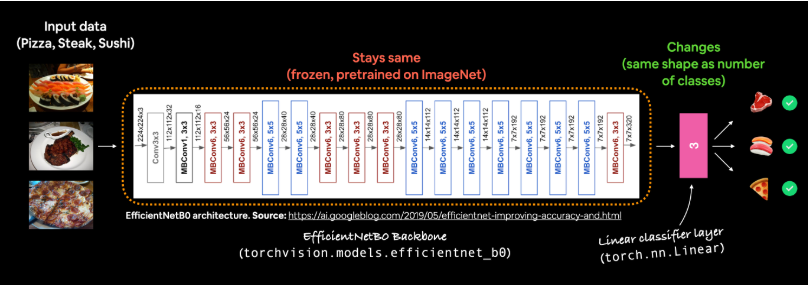

The model has already been trained on millions of images and has a good base representation of image data.

The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

In [14]:
# send it to correct device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

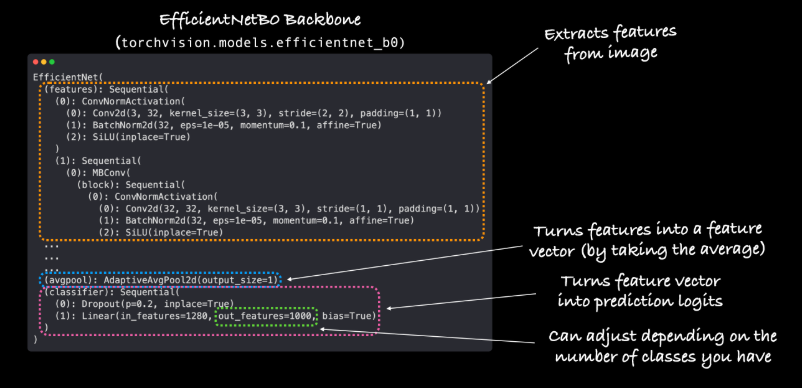


Our efficientnet_b0 comes in three main parts:

- **features** - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as features or feature extractor, "the base layers of the model learn the different features of images").

- **avgpool** - Takes the average of the output of the features layer(s) and turns it into a feature vector.

- **classifier** - Turns the feature vector into a vector with the same dimensionality as the number of required output classes (since efficientnet_b0 is pretrained on ImageNet and because ImageNet has 1000 classes, out_features=1000 is the default).

### 3.2 Summary of model using `torchinfo.summary()`

> Note: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d(), this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to summary() or your models.

- col_names - the various information columns we'd like to see about our model.
- col_width - how wide the columns should be for the summary.
- row_settings - what features to show in a row.

In [16]:
summary(model = model,
        input_size = (32,3,224,224),
        col_names=["input_size" , "output_size" , "num_params" , "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

Now that's a big model!

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

For reference, our model from previous sections, TinyVGG had 8,083 parameters vs. 5,288,548 parameters for efficientnet_b0, an increase of ~654x!



### 3.3 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes:
1. Freeze some base layers of a pretrained model (typically the features section)
2. Then adjust the output layers (also called classifier/head layers) to suit our needs

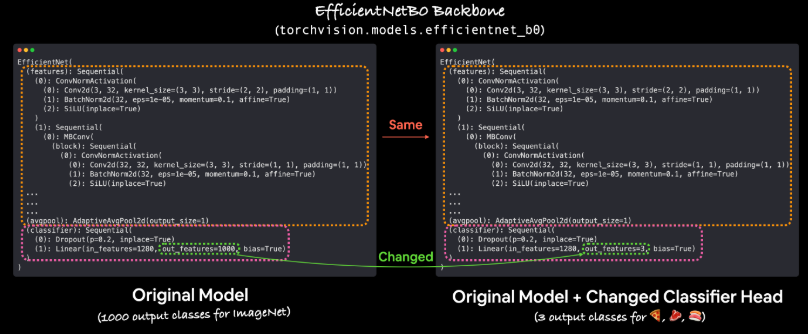

You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original torchvision.models.efficientnet_b0() comes with out_features=1000 because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need out_features=3.

> Note : To freeze layers means to keep them how they are during training . For example: if your model has pretrained layers , to freeze them would be to say "do not change any of the patterns in these layers during training , keep them how they are"

That means , we would like to keep the pretrained weights / patterns our model has learned from ImageNet as a backbone and then only change the output layers.

In PyTorch, `requires_grad` is a boolean attribute of a `torch.Tensor` that determines whether gradients should be computed for that tensor during the backward pass (backpropagation).

- **Automatic Differentiation**: When `requires_grad` is set to ***True*** for a tensor, PyTorch's autograd engine tracks all operations involving that tensor. This allows PyTorch to automatically calculate the gradients of a loss function with respect to that tensor when `loss.backward()` is called.

- **Parameter Optimization**: In neural networks, model parameters (weights and biases) are typically `torch.Tensors`  with `requires_grad=True` by default. This enables optimization algorithms like gradient descent to update these parameters based on the computed gradients to minimize the loss.

- **Freezing Layers**: You can effectively "freeze" parts of a model by setting `requires_grad=False` for the parameters of specific layers. This prevents their gradients from being computed and their values from being updated during training, which is useful in scenarios like transfer learning.



We can freeze all of the layers/parameters in the features section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [19]:
for param in model.features.parameters():
  param.requires_grad=False

The features extractor layer is frozen.

For the classifier , we only want 3 output classes -> pizza steak and sushi so we will change to that . Currently it has 1000 out_features.

So , We can change the classifier portion of our model by creating a new series of layers.

The current classifier consists of:

1. dropout layer ( we can keep it )
2. Linear(in_features = 1280 ,out_features = 1000 , bias = True)

> Note: Dropout layers randomly remove connections between two neural network layers with a probability of p. For example, if p=0.2, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are more general).


In [20]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

output_shape = len(class_names)

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)
).to(device)

In [21]:
summary(model = model,
        input_size = (32,3,224,224),
        verbose=0,
        col_names=["input_size" , "output_size" , "num_params" , "trainable"],
        col_width=20,
        row_settings=["var_names"]
        )

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

- Untrainable layers - Frozen
- Only last layers are trainable
- Final layer output - Same as number of classes


>**Note**: The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

## 4. Train a model

In [22]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

The train() function is in the engine.py script inside the going_modular directory.

Let's see how long it takes to train our model for 5 epochs.

Note: We're only going to be training the parameters classifier here as all of the other parameters in our model have been frozen.

In [28]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_timer = timer()
results = engine.train(model=model,
                       train_dataloader = train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)
end_timer = timer()
print(f"Total training time : {end_timer-start_timer:.4f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3685 | train_acc: 0.9688 | test_loss: 0.4630 | test_acc: 0.8561
Epoch: 2 | train_loss: 0.3401 | train_acc: 0.9688 | test_loss: 0.4276 | test_acc: 0.8759
Epoch: 3 | train_loss: 0.3256 | train_acc: 0.9648 | test_loss: 0.4383 | test_acc: 0.8551
Epoch: 4 | train_loss: 0.3612 | train_acc: 0.8516 | test_loss: 0.4148 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.2978 | train_acc: 0.9766 | test_loss: 0.4328 | test_acc: 0.8561
Total training time : 12.3240 seconds


And it looks like it smashed our previous model results out of the park!

With an efficientnet_b0 backbone, our model achieves almost 85%+ accuracy on the test dataset, almost double what we were able to achieve with TinyVGG.

Not bad for a model we downloaded with a few lines of code.

## 5. Evaluating model by plotting loss curves


In [26]:
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

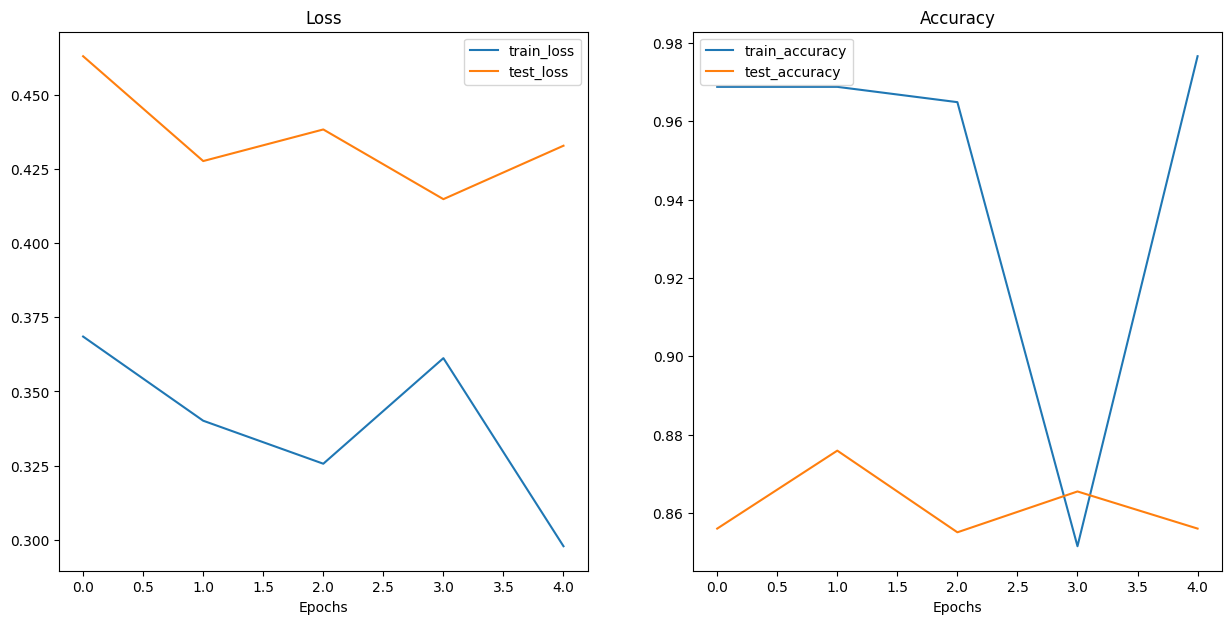

In [29]:
plot_loss_curves(results)

## 6. Make Predictions

Let's make some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in same format as the images our model was trained on.

This means we'll need to make sure our images have:

- **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
- **Same datatype** - If our images are a different datatype (e.g. torch.int8 vs. torch.float32) we'll get datatype errors.
- **Same device** - If our images are on a different device to our model, we'll get device errors.
- **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.


To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

In [30]:
from typing import List , Tuple
from PIL import Image
def pred_and_plot(model:torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # open image
  img = Image.open(image_path)

  # create transform
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

  # predict
  model.to(device)
  model.eval()
  with torch.inference_mode():
    # add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = image_transform(img).unsqueeze(dim=0)
    target_image_pred = model(transformed_image.to(device))

  # convert logits -> pred probs
  target_image_pred_probs = torch.softmax(target_image_pred,dim=1)

  # convert pred probs -> pred labels
  target_image_pred_label = torch.argmax(target_image_pred_probs,dim=1)

  # plot image with pred label and probability
  plt.figure()
  plt.imshow(img)
  plt.title(f"Pred : {class_names[target_image_pred_label]} | Prob : {target_image_pred_probs.max():.3f}")
  plt.axis(False)

Let's test it out by making predictions on a few random images from the test set.

We can get a list of all the test image paths using `list(Path(test_dir).glob("*/*.jpg"))`, the stars in the `glob()` method say "any file matching this pattern", in other words, any file ending in `.jpg` (all of our images).

And then we can randomly sample a number of these using Python's [`random.sample(population, k)`](https://docs.python.org/3/library/random.html#random.sample) where `population` is the sequence to sample and `k` is the number of samples to retrieve.

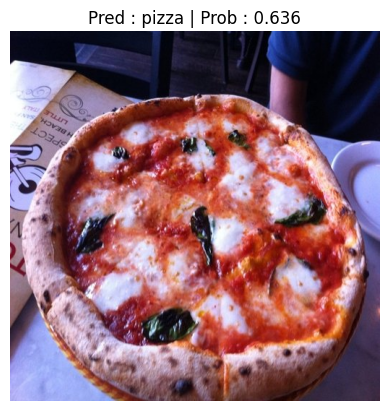

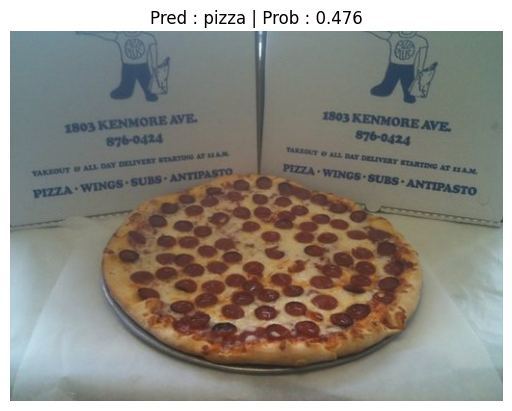

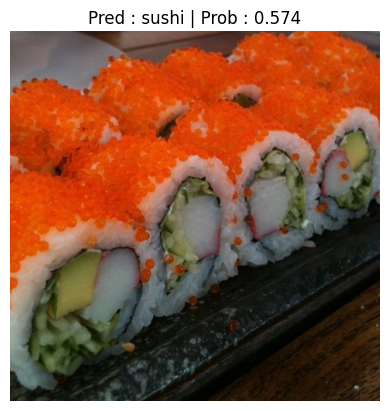

In [33]:
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg"))
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot)
for image_path in test_image_path_sample:
    pred_and_plot(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

## 7. Prediction on custom image

Image saved ✅


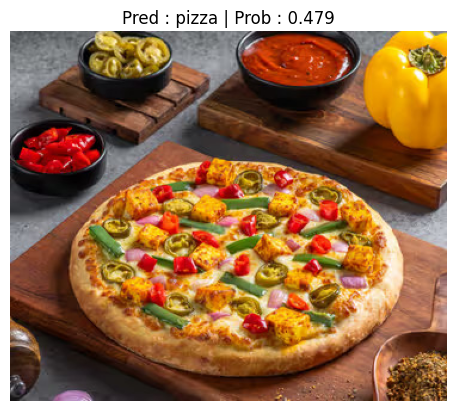

In [39]:
import requests
import os

custom_image_path = data_path / "PIZZA.jpg"

if custom_image_path.exists():
    os.remove(custom_image_path)  # remove corrupted one

url = "https://raw.githubusercontent.com/mahidhiman12/Deep_learning_with_PyTorch/main/custom_image/PIZZAA.jpg"

print(f"Downloading from {url}...")
r = requests.get(url)
with open(custom_image_path, "wb") as f:
    f.write(r.content)

print("Image saved ")

pred_and_plot(model=model, image_path=custom_image_path, class_names=class_names)


Image saved 


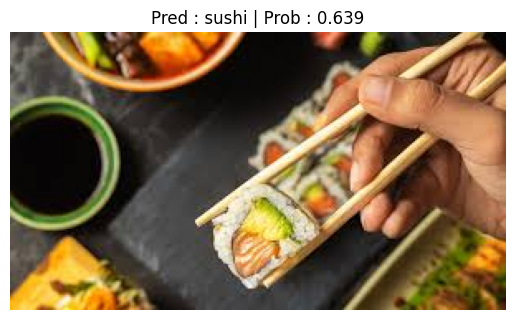

In [41]:
custom_image_path = data_path / "sushi.jpg"

if custom_image_path.exists():
    os.remove(custom_image_path)  # remove corrupted one

url = "https://raw.githubusercontent.com/mahidhiman12/Deep_learning_with_PyTorch/main/custom_image/sushi.jpeg"

print(f"Downloading from {url}...")
r = requests.get(url)
with open(custom_image_path, "wb") as f:
    f.write(r.content)

print("Image saved ")

pred_and_plot(model=model, image_path=custom_image_path, class_names=class_names)